In [2]:
import os
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


In [5]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [6]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

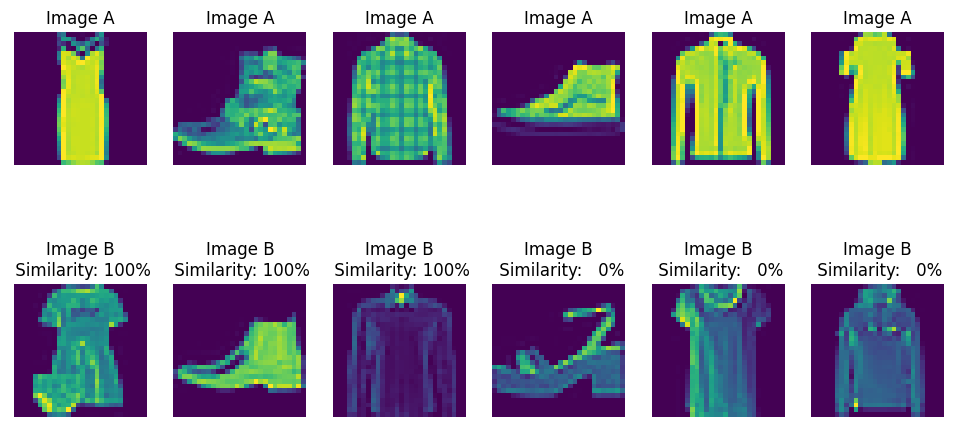

In [7]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size=(3,3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size=(3,3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation='linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs=[img_in], outputs=[n_layer], name='FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24,

In [9]:
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [10]:
similarity_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

In [11]:
def find_simmilar(dataset, image, n_candidates=1024, finalists=4):
    candidates, preds = [], []
    for i in range(n_candidates):
        candidates.append(dataset[np.random.choice(range(len(dataset)))])
    compiled = [np.tile(image, (n_candidates, 1, 1, 1)), np.stack(candidates)]
    print(compiled[0].shape, compiled[1].shape)
    preds = similarity_model.predict(compiled).reshape(-1)
    print(preds.shape)
    top = np.argpartition(preds, -finalists)[-finalists:]
    for i in top:
        plt.imshow(candidates[i][:, :, 0])
        plt.show()
        print(preds[i])

1/1 [==============================] - 0s 322ms/step


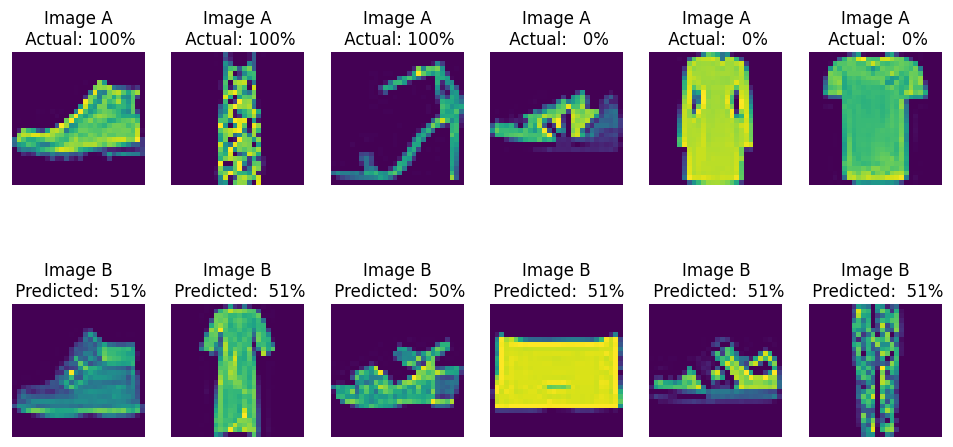

In [12]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [13]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10
500/500 [==============================] - 20s 36ms/step - loss: 0.6719 - mae: 0.4818 - val_loss: 0.5718 - val_mae: 0.4232

1/1 [==============================] - 0s 16ms/step


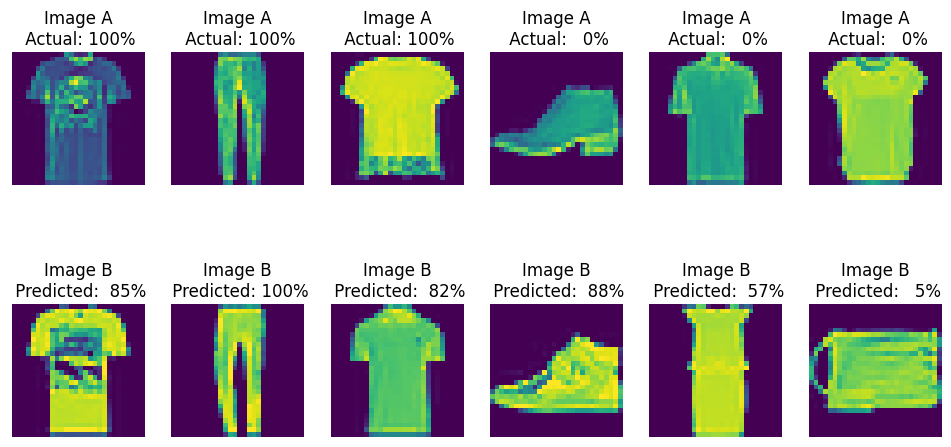

In [14]:
_ = show_model_output()


In [15]:
image = x_train[1488]

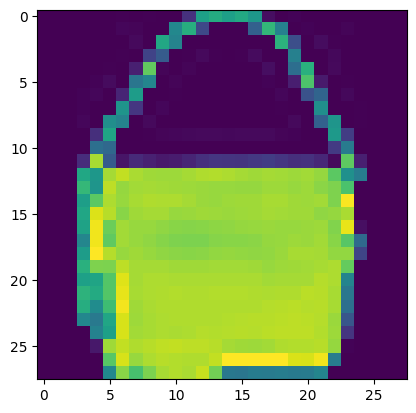

In [16]:
plt.imshow(image[:, :, 0])

(1024, 28, 28, 1) (1024, 28, 28, 1)
32/32 [==============================] - 0s 5ms/step
(1024,)


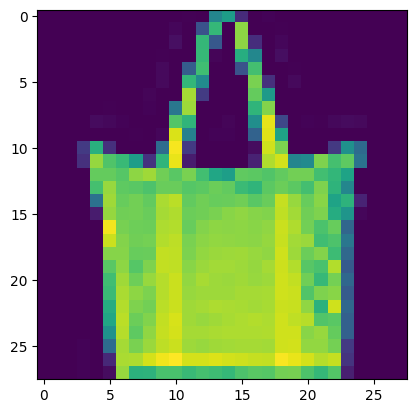

0.98969775


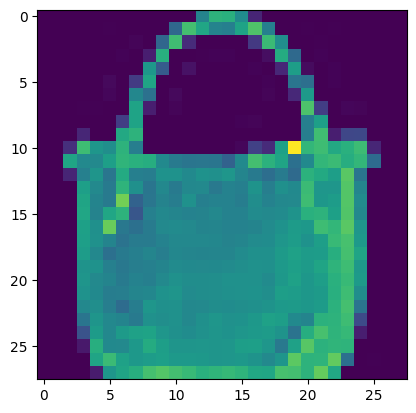

0.99034196


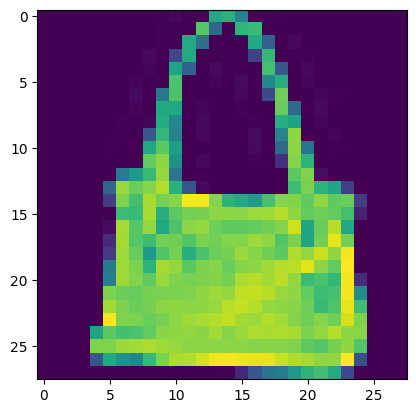

0.990044


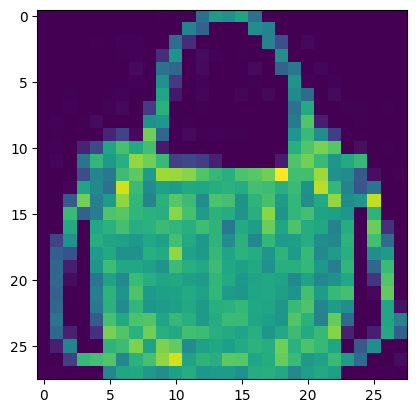

0.9900064


In [17]:
find_simmilar(x_train, image)

In [18]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0], 0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose=True, batch_size=128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0], 0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose=True, batch_size=128)

79/79 [==============================] - 1s 15ms/step

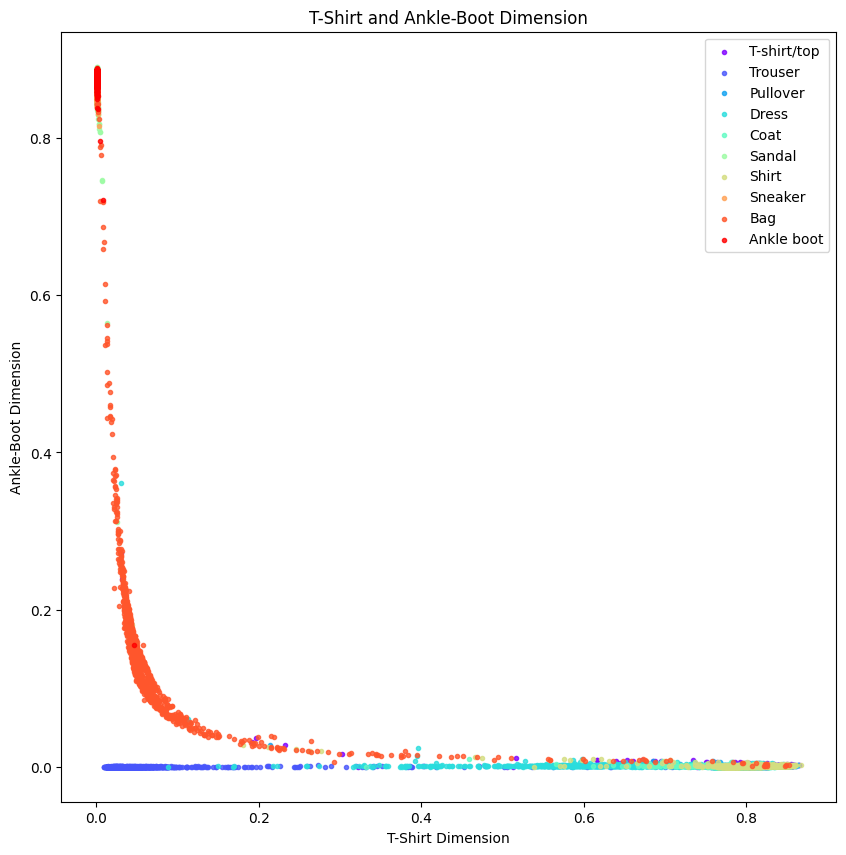

In [19]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(y_test == c_group), 0],
        ankle_boot_score[np.where(y_test == c_group), 0],
        marker='.',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('dimension.png')

In [20]:
x_test_features = feature_model.predict(
    x_test,
    verbose=True,
    batch_size=128
)


79/79 [==============================] - 1s 9ms/step


In [21]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.250s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.104080
[t-SNE] Computed conditional probabilities in 0.261s
[t-SNE] Iteration 50: error = 83.6798248, gradient norm = 0.0211579 (50 iterations in 1.610s)
[t-SNE] It

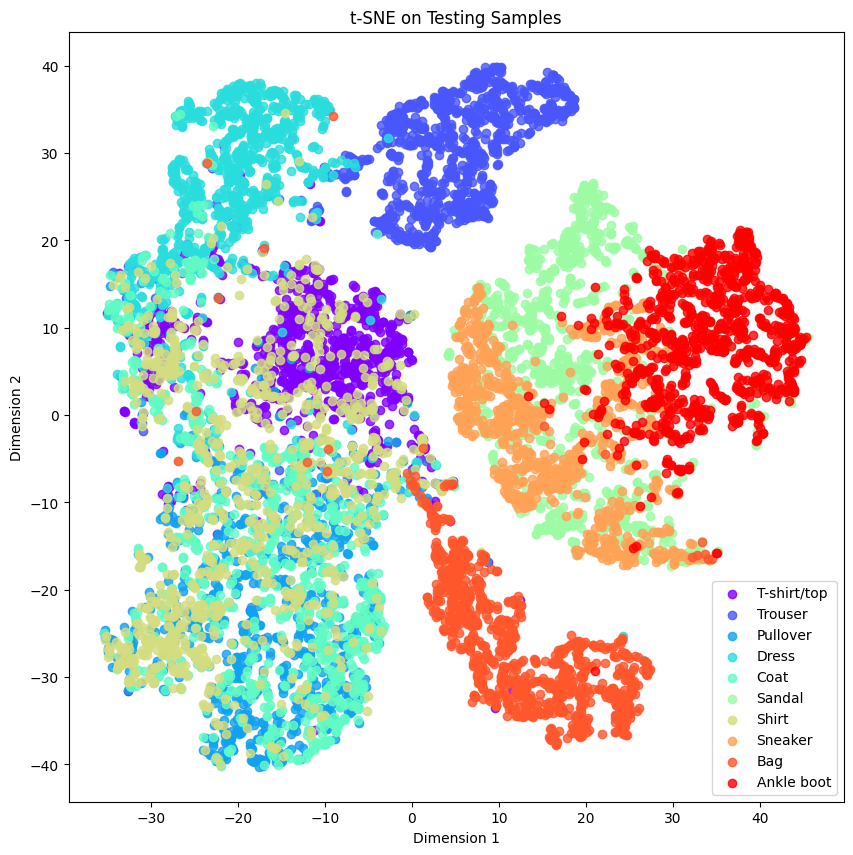

In [22]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

### PREPROC

In [23]:
from tensorflow.keras.utils import img_to_array, array_to_img
from sklearn.model_selection import train_test_split

In [24]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.shape

(60000, 28, 28)

In [25]:
x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test] * 3)
x_train.shape, x_test.shape

((60000, 28, 84), (10000, 28, 84))

In [26]:
x_train = x_train.reshape(-1, 28, 28, 3)
x_test = x_test.reshape(-1, 28, 28, 3)

print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (60000, 28, 28, 3) 255
Testing (10000, 28, 28, 3) 255


In [27]:
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((128, 128))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((128, 128))) for im in x_test])
x_train.shape, x_test.shape

((60000, 128, 128, 3), (10000, 128, 128, 3))

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
x_train, x_valid, train_label, valid_label = train_test_split(x_train,y_train_one_hot,test_size=0.2,random_state=13)

### MODEL InceptionV1

In [ ]:
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation , BatchNormalization, ReLU
from tensorflow.keras import optimizers
from keras import models, layers, callbacks, initializers

In [ ]:
def conv2d_with_Batch(prev_layer , nbr_kernels , filter_size , strides = (1,1) , padding = 'same'):
    kernel_init = initializers.glorot_uniform()
    x = Conv2D(filters = nbr_kernels, kernel_size = filter_size, strides=strides , padding=padding, kernel_initializer=kernel_init) (prev_layer)
    x = BatchNormalization()(x)
    x = Activation(activation = 'relu') (x)
    return x

def inception_module(prev_layer,filters_1x1,filters_3x3_reduce,filters_3x3,
    filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    conv_1x1 = conv2d_with_Batch(prev_layer, nbr_kernels = filters_1x1, filter_size = (1, 1))

    conv_3x3 = conv2d_with_Batch(prev_layer, nbr_kernels = filters_3x3_reduce,  filter_size = (1, 1) )
    conv_3x3 = conv2d_with_Batch(conv_3x3, nbr_kernels = filters_3x3,  filter_size = (3, 3) )

    conv_5x5 = conv2d_with_Batch(prev_layer, nbr_kernels = filters_5x5_reduce,  filter_size = (1, 1))
    conv_5x5 = conv2d_with_Batch(conv_5x5, nbr_kernels = filters_5x5,  filter_size = (5, 5))

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(prev_layer)
    pool_proj = conv2d_with_Batch(pool_proj, nbr_kernels = filters_pool_proj,  filter_size = (1, 1))

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    return output


def InceptionV1():
    input_layer = Input(shape=(128 , 128 , 3))
    kernel_init = initializers.glorot_uniform()

    x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
    x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
    x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)
    x = inception_module(x,filters_1x1=64,filters_3x3_reduce=96, filters_3x3=128,filters_5x5_reduce=16, filters_5x5=32,filters_pool_proj=32, name='inception_3a')
    x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128, filters_3x3=192,filters_5x5_reduce=32, filters_5x5=96,filters_pool_proj=64, name='inception_3b')
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
    x = inception_module(x,filters_1x1=192,filters_3x3_reduce=96, filters_3x3=208,filters_5x5_reduce=16,filters_5x5=48,filters_pool_proj=64, name='inception_4a')
    x1 = AveragePooling2D((5, 5), strides=3)(x)
    x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
    x1 = Flatten()(x1)
    x1 = Dense(1024, activation='relu')(x1)
    x1 = Dropout(0.7)(x1)
    x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)
    x = inception_module(x,filters_1x1=160,filters_3x3_reduce=112, filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj=64,name='inception_4b')
    x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128, filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64, filters_pool_proj=64,name='inception_4c')
    x = inception_module(x,filters_1x1=112,filters_3x3_reduce=144, filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64, filters_pool_proj=64, name='inception_4d')
    x2 = AveragePooling2D((5, 5), strides=3)(x)
    x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1024, activation='relu')(x2)
    x2 = Dropout(0.7)(x2)
    x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)
    x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool_proj=128, name='inception_4e')
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
    x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool_proj=128, name='inception_5a')
    x = inception_module(x, filters_1x1=384,filters_3x3_reduce=192, filters_3x3=384,filters_5x5_reduce=48,filters_5x5=128, filters_pool_proj=128, name='inception_5b')
    x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
    x = Dropout(0.4)(x)
    x = Dense(10, activation='softmax', name='output')(x)

    model = Model(input_layer, [x, x1, x2], name='inception_v1')


    return model

In [ ]:
model = InceptionV1()
model.summary()

In [ ]:
train_features = model.predict(x_train, batch_size=64, verbose=1)
test_features = model.predict(x_test, batch_size=64, verbose=1)
val_features = model.predict(x_valid, batch_size=64, verbose=1)

In [ ]:
train_features_flat = np.reshape(train_features, (48000, -1))
test_features_flat = np.reshape(test_features, (10000, -1))
val_features_flat = np.reshape(val_features, (12000, -1))

In [ ]:
train_features_flat.shape

In [ ]:
### CLASSIFIER LAYER

### CLASSIFIER LAYER

In [ ]:
model = models.Sequential()
model.add(layers.Dense(1000, activation='relu', input_dim=(1000)))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
reduce_lr = callbacks.ReduceLROnPlateau(
    factor=0.2,
    patience=2,
    verbose=1,
    cooldown=2
)

In [ ]:
history = model.fit(
    train_features_flat,
    train_label,
    epochs=10,
    validation_data=(val_features, valid_label),
    callbacks=[reduce_lr]
)

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuray = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()